In [ ]:
from __future__ import division
import os
import time
import argparse
import torch
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR, MultiStepLR
import torch.nn.functional as F
from utils import accuracy, AverageMeter, save_checkpoint, visualize_graph, get_parameters_size
from torch.utils.tensorboard import SummaryWriter
from net_factory import get_network_fn


# dataset
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.nn import DataParallel
import tqdm


In [ ]:

parser = argparse.ArgumentParser(description='PyTorch GCN MNIST Training')

parser.add_argument('--epochs', default=50, type=int, metavar='N',
                    help='number of total epochs to run')
parser.add_argument('-j', '--workers', default=4, type=int, metavar='N',
                    help='number of data loading workers (default: 4)')
parser.add_argument('--start-epoch', default=0, type=int, metavar='N',
                    help='manual epoch number (useful on restarts)')
parser.add_argument('-b', '--batch-size', default=128, type=int,
                    metavar='N', help='mini-batch size (default: 64)')
parser.add_argument('--lr', '--learning-rate', default=0.01, type=float,
                    metavar='LR', help='initial learning rate')
parser.add_argument('--momentum', default=0.9, type=float, metavar='M',
                    help='momentum')
parser.add_argument('--print-freq', '-p', default=10, type=int,
                    metavar='N', help='print frequency (default: 10)')
parser.add_argument('--resume', default='', type=str, metavar='PATH',
                    help='path to latest checkpoint (default: none)')
parser.add_argument('--pretrained', default='', type=str, metavar='PATH',
                    help='path to pretrained checkpoint (default: none)')
parser.add_argument('--gpu', default=0, type=int,
                    metavar='N', help='GPU device ID (default: -1)')
parser.add_argument('--dataset_dir', default='../../MNIST', type=str, metavar='PATH',
                    help='path to dataset (default: ../MNIST)')
parser.add_argument('--comment', default='', type=str, metavar='INFO',
                    help='Extra description for tensorboard')
parser.add_argument('--model', default='gcn', type=str, metavar='NETWORK',
                    help='Network to train')

args = parser.parse_args(args=[])

use_cuda = (args.gpu >= 0) and torch.cuda.is_available()
best_prec1 = 0
writer = SummaryWriter(comment='_'+args.model+'_'+args.comment)
iteration = 0

# # from loaddataset import load_data
# from loaddataset import load_data

# batch_size = 64
# train_loader = DataLoader(load_data(training=True), batch_size=batch_size, shuffle=True)  # ,prefetch_factor=2
# test_loader = DataLoader(load_data(training=False), batch_size=batch_size, shuffle=True)  # ,prefetch_factor=2


In [ ]:

# Load model
model = get_network_fn(name='gcn')#GCNCNN
# print(model)

# Try to visulize the model
try:
	visualize_graph(model, writer, input_size=(1, 3, 128, 128))
except:
	print('\nNetwork Visualization Failed! But the training procedure continue.')


In [ ]:
# from torchvision import datasets, models, transforms

# model = models.resnet18(pretrained=True)
# num_ftrs = model.fc.in_features
# # Here the size of each output sample is set to 2.
# # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
# model.fc = nn.Linear(num_ftrs, 450)


In [ ]:
import numpy as np
import os
import cv2
from  matplotlib import pyplot as plt

## torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

# dataset
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.nn import DataParallel
import tqdm


# read image
import PIL
from PIL import Image
from utils import *

ms_polyu_path = 'dataset/MS_PolyU/'
casia_path = 'dataset/CASIA-Multi-Spectral-PalmprintV1/images/'

r_img_path = ms_polyu_path + 'Red_ind/'
b_img_path =  ms_polyu_path + 'Blue_ind/'
g_img_path =  ms_polyu_path + 'Green_ind/'
n_img_path =  ms_polyu_path + 'NIR_ind/'

################ DATASET CLASS
def one_hot_embedding(labels, num_classes):
    """Embedding labels to one-hot form.

    Args:
      labels: (LongTensor) class labels, sized [N,].
      num_classes: (int) number of classes.

    Returns:
      (tensor) encoded labels, sized [N, #classes].
    """
    y = torch.eye(num_classes) 
    return y[labels] 
# one_hot_embedding(1, 10)
def part_init(istrain=True):
    r_list = []
    b_list = []
    n_list = []
    labels = []
    
        # split all data into train, test data
    train_ratio = 0.9
    train_num = int(500 * train_ratio)
    print("split train users:",train_num)
    if istrain:
        for i in tqdm.tqdm(range(train_num)):
            for j in range(12):
                r_img = np.array(Image.open(os.path.join(r_img_path, "%04d_"%(i+1)+"%04d.jpg"%(j+1))))

                g_img = np.array(Image.open(os.path.join(g_img_path, "%04d_"%(i+1)+"%04d.jpg"%(j+1))))
                
                b_img = np.array(Image.open(os.path.join(b_img_path, "%04d_"%(i+1)+"%04d.jpg"%(j+1))))

                n_img = np.array(Image.open(os.path.join(n_img_path, "%04d_"%(i+1)+"%04d.jpg"%(j+1))))
                
                img = np.dstack((r_img,g_img,n_img))
                
                n_list.append(img)
                # labels.append(one_hot_embedding(i, train_num))
                labels.append(i)
    else:
        for i in tqdm.tqdm(range(train_num,500)):
            for j in range(12):
                r_img = np.array(Image.open(os.path.join(r_img_path, "%04d_"%(i+1)+"%04d.jpg"%(j+1))))

                g_img = np.array(Image.open(os.path.join(g_img_path, "%04d_"%(i+1)+"%04d.jpg"%(j+1))))
                
                b_img = np.array(Image.open(os.path.join(b_img_path, "%04d_"%(i+1)+"%04d.jpg"%(j+1))))

                n_img = np.array(Image.open(os.path.join(n_img_path, "%04d_"%(i+1)+"%04d.jpg"%(j+1))))
                
                img = np.dstack((r_img,g_img,n_img))
                
                n_list.append(img)
                # labels.append(one_hot_embedding(i, train_num))
                labels.append(i)



    # return np.array(r_list), np.array(b_list), np.array(n_list), np.array(labels),np.array(r_list_test), np.array(b_list_test), np.array(n_list_test), np.array(labels_test)
    return  n_list, labels

# r_list, b_list, n_list, labels,r_list_test, b_list_test, n_list_test, labels_test = part_init()
class load_data(Dataset):
    """Loads the Data."""
    def __init__(self, training=True):

        self.training = training
#         r_list, b_list, n_list, labels,r_list_test, b_list_test, n_list_test, labels_test = part_init()
        self.transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomRotation(degrees=15),
        transforms.RandomPerspective(),
        transforms.RandomAffine(30),
#         transforms.Resize((224, 224)),# if resnet
        transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406],
#                              [0.229, 0.224, 0.225]),
    ])
        self.transform_test = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
#         transforms.Resize((224, 224)),# if resnet
#         transforms.Normalize([0.485, 0.456, 0.406],
#                              [0.229, 0.224, 0.225]),
    ])
        if self.training:
            print('\n...... Train files loading\n')
            self.n_list, self.labels= part_init(istrain=True)
            print('\nTrain files loaded ......\n')
        else:
            print('\n...... Test files loading\n')
            self.n_list, self.labels = part_init(istrain=False)
            print('\nTest files loaded ......\n')

    def __len__(self):
        return len(self.n_list)

         
    def __getitem__(self, idx):

#         trans = transforms.Compose([
#         transforms.Grayscale(num_output_channels=3),
#         transforms.RandomResizedCrop(size=128, scale=(0.8, 1.0)),
#         transforms.RandomRotation(degrees=15),
#         transforms.CenterCrop(size=128),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406],
#                              [0.229, 0.224, 0.225])])
        if self.training:
            n_img = self.transform(self.n_list[idx])
        else:
            n_img = self.transform_test(self.n_list[idx])
        label = self.labels[idx]

        return n_img,label


In [ ]:

batch_size = 512
train_loader = DataLoader(load_data(training=True), batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True,prefetch_factor=8)  # ,prefetch_factor=2
# test_loader = DataLoader(load_data(training=False), batch_size=batch_size, shuffle=True)  # ,prefetch_factor=2


In [ ]:
for _, img in tqdm.tqdm(enumerate(train_loader)):
    print((img[0].size(), img[1].size()))
    break
    
# for _, img in tqdm.tqdm(enumerate(test_loader)):
#     print((img[0].size(), img[1].size()))
#     break

In [10]:

# optimizer = optim.Adadelta(model.parameters(), lr=args.lr, rho=0.9, eps=1e-06, weight_decay=3e-05)
# optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=3e-05)
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=3e-05)
scheduler = StepLR(optimizer, step_size=10, gamma=0.99)
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda" if use_cuda else "cpu")
model = model.to(device)
criterion = criterion.to(device)

# Calculate the total parameters of the model
print('Model size: {:0.2f} million float parameters'.format(get_parameters_size(model)/1e6))

if args.pretrained:
    if os.path.isfile(args.pretrained):
        print("=> loading checkpoint '{}'".format(args.pretrained))
        checkpoint = torch.load(args.pretrained)
        model.load_state_dict(checkpoint['state_dict'])
    else:
        print("=> no checkpoint found at '{}'".format(args.pretrained))

def train(epoch):
    model.train()
    global iteration
    st = time.time()
    for batch_idx, img in enumerate(train_loader):
        rbn = img[0].to(device, dtype=torch.float)
        label = img[1].to(device)
        alpha = 0.5  #1 is a scaling factor
        model.train()
#         print(rbn.size())
        #  r_diff n is vein  RGB is print
#         vein = torch.cat([r_diff,n], dim=1)
#         pprint = torch.cat([r,b], dim=1)
#         inputs = torch.cat([r,b,n], dim=1)
        inputs = rbn
        iteration += 1
        optimizer.zero_grad()
        output = model(inputs)
        prec1, = accuracy(output, label)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        if batch_idx % args.print_freq == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}, lr: {:.5f}'.format(
                epoch, batch_idx * len(inputs), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), prec1.item(),optimizer.param_groups[0]['lr']))
            writer.add_scalar('Loss/Train', loss.item(), iteration)
            writer.add_scalar('Accuracy/Train', prec1, iteration)
    epoch_time = time.time() - st
    print('Epoch time:{:0.2f}s'.format(epoch_time))
    scheduler.step()

def test(epoch):
    model.eval()
    test_loss = AverageMeter()
    acc = AverageMeter()
 
    print('\nTest set: Average loss: {:.4f}, Accuracy: {:.2f}%\n'.format(test_loss.avg, acc.avg))
    writer.add_scalar('Loss/Test', test_loss.avg, epoch)
    writer.add_scalar('Accuracy/Test', acc.avg, epoch)
    return acc.avg

for epoch in range(args.start_epoch, 1000):
    print('------------------------------------------------------------------------')
    train(epoch+1)
#     prec1 = test(epoch+1)

#     # remember best prec@1 and save checkpoint
#     is_best = prec1 > best_prec1
#     best_prec1 = max(prec1, best_prec1)
#     save_checkpoint({
#         'epoch': epoch + 1,
#         'state_dict': model.state_dict(),
#         'best_prec1': best_prec1,
#         'optimizer' : optimizer.state_dict(),
#     }, is_best)

print('Finished!')
print('Best Test Precision@top1:{:.2f}'.format(best_prec1))
writer.add_scalar('Best TOP1', best_prec1, 0)
writer.close()

Model size: 0.97 million float parameters
------------------------------------------------------------------------
Train Epoch: 1 [0/5400 (0%)]	Loss: 0.242451, Accuracy: 94.92, lr: 0.01000
Train Epoch: 1 [2800/5400 (91%)]	Loss: 0.217546, Accuracy: 95.71, lr: 0.01000
Epoch time:10.71s
------------------------------------------------------------------------
Train Epoch: 2 [0/5400 (0%)]	Loss: 0.297109, Accuracy: 93.55, lr: 0.01000
Train Epoch: 2 [2800/5400 (91%)]	Loss: 0.261186, Accuracy: 95.00, lr: 0.01000
Epoch time:9.30s
------------------------------------------------------------------------
Train Epoch: 3 [0/5400 (0%)]	Loss: 0.276405, Accuracy: 95.70, lr: 0.01000
Train Epoch: 3 [2800/5400 (91%)]	Loss: 0.157573, Accuracy: 97.14, lr: 0.01000
Epoch time:12.90s
------------------------------------------------------------------------
Train Epoch: 4 [0/5400 (0%)]	Loss: 0.281638, Accuracy: 93.95, lr: 0.01000
Train Epoch: 4 [2800/5400 (91%)]	Loss: 0.231794, Accuracy: 96.79, lr: 0.01000
Epoch

KeyboardInterrupt: 

In [12]:
test_loader = DataLoader(load_data(training=False), batch_size=batch_size, shuffle=False)  # ,prefetch_factor=2


...... Test files loading

split train users: 450


100%|██████████| 50/50 [00:02<00:00, 22.10it/s]


Test files loaded ......



In [14]:
##### HELPER FUNCTION FOR FEATURE EXTRACTION
print(model)
def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook
##### REGISTER HOOK

model.fc1.register_forward_hook(get_features('feats'))

GCN(
  (model): Sequential(
    (0): GConv(3, 10, kernel_size=(4, 5, 5), stride=(1, 1), bias=False)
    (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): GConv(10, 20, kernel_size=(4, 5, 5), stride=(2, 2), bias=False)
    (4): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): GConv(20, 40, kernel_size=(4, 5, 5), stride=(2, 2), bias=False)
    (8): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): GConv(40, 80, kernel_size=(4, 5, 5), stride=(2, 2), bias=False)
    (12): BatchNorm2d(320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
  )
  (fc1): Linear(in_features=80, out

In [15]:
FEATS = []
GT = []
features = {}
def test():
    model.eval()
    test_loss = AverageMeter()
    acc = AverageMeter()
    with torch.no_grad():
        for batch_idx, img in enumerate(test_loader):
            rbn = img[0].to(device, dtype=torch.float)
            label = img[1].to(device)

            output = model(rbn)
            FEATS.append(features['feats'].cpu().numpy())
            GT.append(img[1].numpy())

  
    return acc.avg

test()
##### INSPECT FEATURES


0

In [16]:

FEATS = np.concatenate(FEATS)
GT = np.concatenate(GT)

print('- feats shape:', FEATS.shape)
print('- GT shape:', GT.shape)


- feats shape: (600, 1024)
- GT shape: (600,)


In [18]:
from numpy import dot
from numpy.linalg import norm

def cossim(a,b):
    return dot(a, b)/(norm(a)*norm(b))

pred_scores = []
gt_label = []

for i in tqdm.tqdm(range(600)):
    for j in range(i+1,600):
        # pred_scores.append(final[i,j].detach().cpu().numpy())
        pred_scores.append(cossim(FEATS[i,:],FEATS[j,:]))
        gt_label.append(i//12 == j//12)
        

# for i in tqdm.tqdm(range(600)):
#         # pred_scores.append(final[i,j].detach().cpu().numpy())
#         pred_scores.append(cossim(FEATS[i,:],FEATS[]))
#         # gt_label.append(i//12 == j//12)
pred_scores = np.array(pred_scores)
gt_label = np.array(gt_label)

100%|██████████| 600/600 [00:05<00:00, 109.34it/s]


Traceback (most recent call last):
  File "/root/miniconda3/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/root/miniconda3/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/root/miniconda3/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/root/miniconda3/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/root/miniconda3/lib/python3.8/multiprocessing/queues.py", line 235, in _feed
    close()
  File "/root/miniconda3/lib/python3.8/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/root/miniconda3/lib/python3.8/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
/root/miniconda3/lib/python3.8/sit

Text(0, 0.5, 'Density')

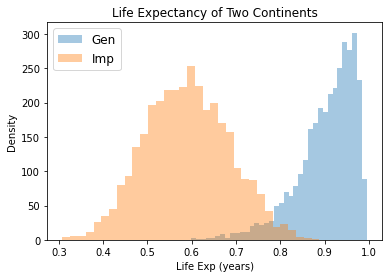

In [19]:

Gen = pred_scores[gt_label]
Imp = pred_scores[gt_label==False]
Imp = Imp[np.random.permutation(len(Imp))[:len(Gen)]]


import seaborn as sns
sns.distplot(Gen,  kde=False, label='Gen')
# df =gapminder[gapminder.continent == 'Americas']
sns.distplot(Imp,  kde=False,label='Imp')
# Plot formatting
plt.legend(prop={'size': 12})
plt.title('Life Expectancy of Two Continents')
plt.xlabel('Life Exp (years)')
plt.ylabel('Density')

In [21]:
import numpy as np
import sklearn.metrics

"""
Python compute equal error rate (eer)
ONLY tested on binary classification

:param label: ground-truth label, should be a 1-d list or np.array, each element represents the ground-truth label of one sample
:param pred: model prediction, should be a 1-d list or np.array, each element represents the model prediction of one sample
:param positive_label: the class that is viewed as positive class when computing EER
:return: equal error rate (EER)
"""
def compute_eer(label, pred, positive_label=1):
    # all fpr, tpr, fnr, fnr, threshold are lists (in the format of np.array)
    fpr, tpr, threshold = sklearn.metrics.roc_curve(label, pred)#, positive_label
    fnr = 1 - tpr

    # the threshold of fnr == fpr
    eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]

    # theoretically eer from fpr and eer from fnr should be identical but they can be slightly differ in reality
    eer_1 = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
    eer_2 = fnr[np.nanargmin(np.absolute((fnr - fpr)))]

    # return the mean of eer from fpr and from fnr
    eer = (eer_1 + eer_2) / 2
    return eer

eer = compute_eer(gt_label, pred_scores)
print('The equal error rate is {:.6f}'.format(eer))

The equal error rate is 0.037236


In [ ]:
# !pip install sklearn